In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

import gc
import optuna

from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight

In [2]:
PATH = '/kaggle/input/ad-clicks/data.csv'
data = pd.read_csv(PATH)

Датасет состоит из показов рекламы.

- date_time - время показа рекламы
- zone_id - id зоны, где зона - место на сайте для размещения рекламы
- banner_id - id баннера, где баннер - сама реклама
- campaign_clicks - общее количество показов данной кампании (которой соотвествует баннер) данному юзеру, произошедшие до текущего показа. - - - Кампанию стоит понимать как что-то общее (рекламодатель/тематика/ и т. п.) для баннеров.
- os_id - id операционной системы
- country_id - id страны
- impressions - был ли показ
- clicks - был ли клик


Для Домашней работы 1, колонки: oaid_hash, banner_id0, banner_id1, rate0, rate1, g0, g1, coeff_sum0, coeff_sum1 использовать не нужно! Они будут использоваться в последующих Домашних работах.

baseline -- среднее значение

In [3]:
# Вытащим используемые фичи
# impressions все равны 1, их нет смысла брать
data = data[['date_time', 'zone_id', 'os_id', 'banner_id', 'campaign_clicks', 'country_id', 'clicks']]
data.head()

,date_time,zone_id,os_id,banner_id,campaign_clicks,country_id,clicks
0,2021-09-27 00:01:30.000000,0,0,0,0,0,1
1,2021-09-26 22:54:49.000000,1,0,1,0,1,1
2,2021-09-26 23:57:20.000000,2,0,2,3,0,1
3,2021-09-27 00:04:30.000000,3,1,3,0,1,1
4,2021-09-27 00:06:21.000000,4,1,4,0,0,1


In [4]:
# переведем даты в дни недели и часы, переведем все числовые данные в тип, который занимает меньший объем памяти
numeric_cols = data.select_dtypes(include='number').columns.tolist()
data[numeric_cols] = data[numeric_cols].astype('int16')
data['date_time'] = pd.to_datetime(data['date_time'])
data['hour'] = data['date_time'].dt.hour.astype('int16')
data['day_number'] = data['date_time'].dt.weekday.astype('int16')


Перед анализом данных уберем тестовую выборку

In [5]:
# разделим данные на трейн и тест
max_date = data['date_time'].dt.date.max()
test_data = data[data['date_time'].dt.date == max_date].drop(columns=['date_time'])
train_data = data[data['date_time'].dt.date < max_date].drop(columns=['date_time'])

gc.collect()

0

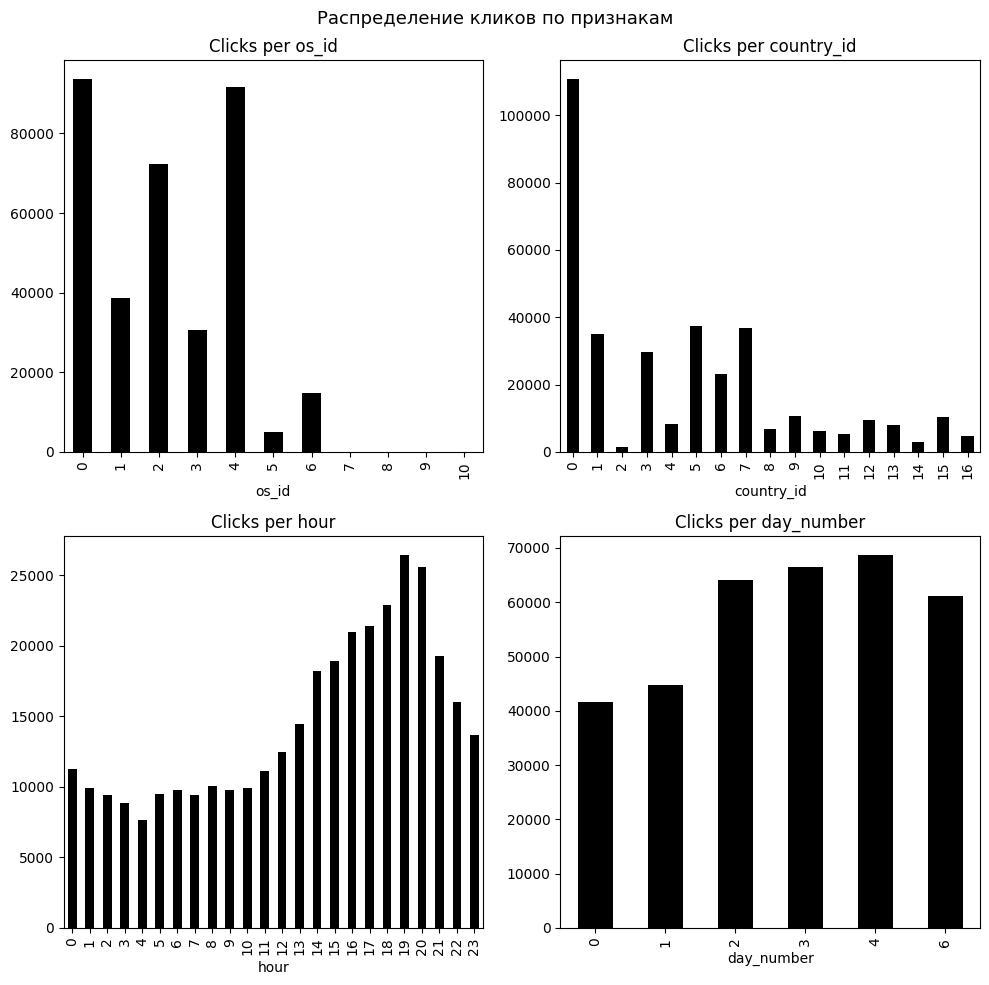

In [6]:
# Посмотрим на кол-во кликов по разным фичам. Сперва посмотрим на более удобные в отображении признаки

features_1 = ['os_id', 'country_id', 'hour', 'day_number']

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
plot_index = 0

for i in range(2):
    for j in range(2):
        clicks_per_feature = train_data.groupby(features_1[plot_index])['clicks'].sum()
        ax = axs[i, j]
        clicks_per_feature.plot(kind='bar', color='black', ax=ax)
        ax.set_title(f'Clicks per {features_1[plot_index]}')
        plot_index += 1

fig.suptitle('Распределение кликов по признакам', fontsize=13)
plt.tight_layout()
plt.show()

Количество кликов по этим признакам распределено довольно разнообразно, выбросов мало

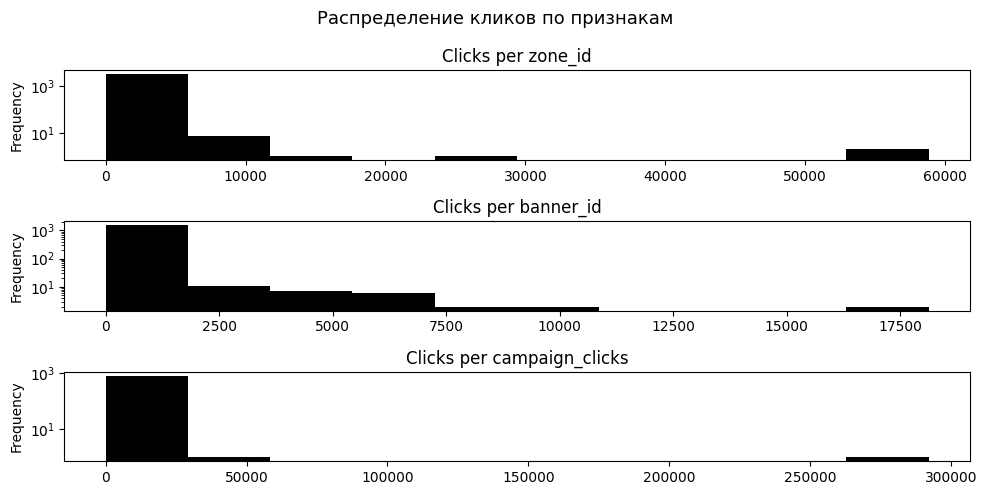

In [14]:
features_2 = ['zone_id', 'banner_id', 'campaign_clicks']

fig, axs = plt.subplots(3, 1, figsize=(10, 5))
plot_index = 0

for j in range(3):
    clicks_per_feature = train_data.groupby(features_2[plot_index])['clicks'].sum()
    ax = axs[j]
    clicks_per_feature.plot(kind='hist', color='black', ax=ax, logy=True)
    ax.set_title(f'Clicks per {features_2[plot_index]}')
    plot_index += 1

fig.suptitle('Распределение кликов по признакам', fontsize=13)
plt.tight_layout()
plt.show()

Ну тут распределение какое-то менее приятное получилось.

Добавим в качестве признака номер часа от начала недели.

In [15]:
train_data['week_hour'] = (train_data['hour'] + 1) * (train_data['day_number'] + 1)
test_data['week_hour'] = (test_data['hour'] + 1) * (test_data['day_number'] + 1)

<Axes: xlabel='week_hour'>

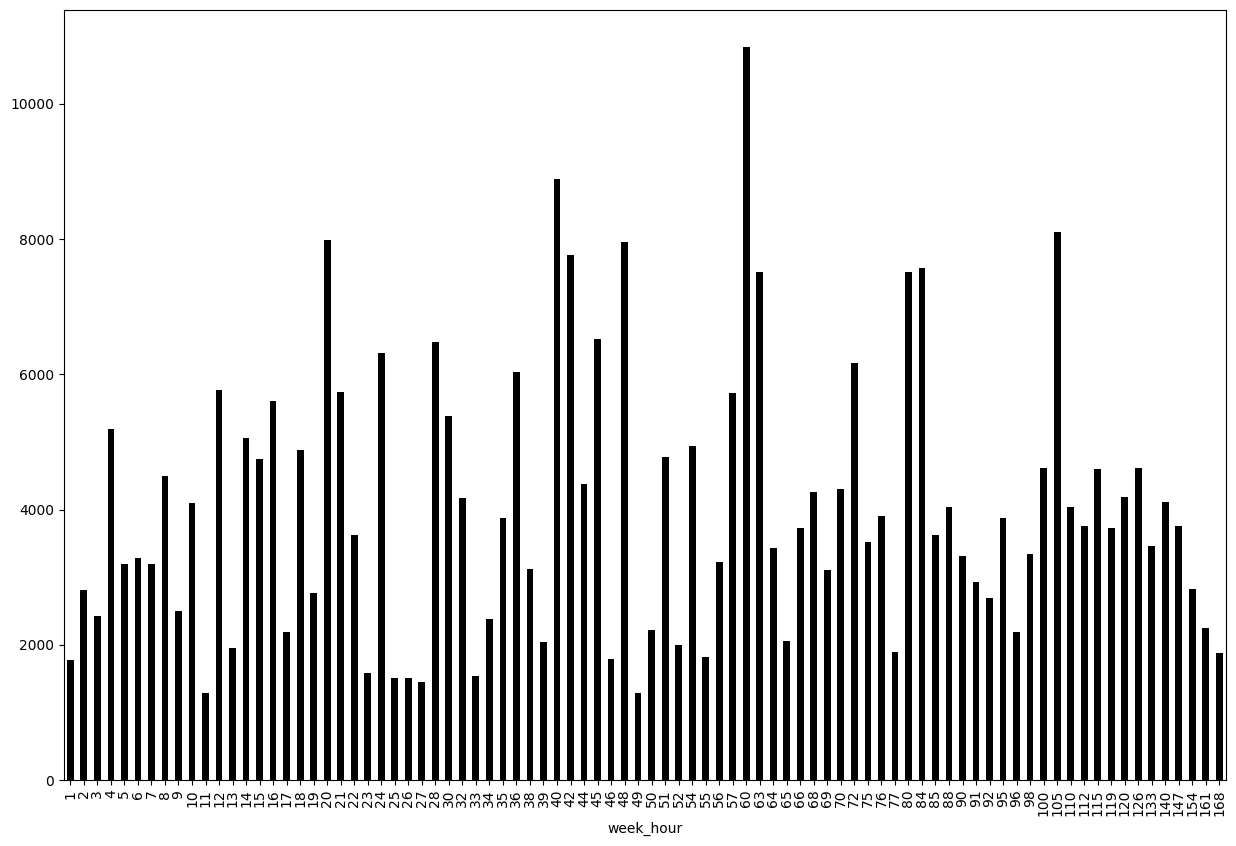

In [16]:
clicks_per_feature = train_data.groupby('week_hour')['clicks'].sum()
clicks_per_feature.plot(kind='bar', color='black', figsize=(15, 10))

Получаем тоже достаточно хорошее распределение кликов

In [10]:
y = test_data['clicks']
pred = np.ones_like(test_data['clicks']) * y.mean()
baseline = (y == 0).sum() / len(y)
print(f"auc: {metrics.roc_auc_score(y, pred)}")
print(f"log_loss: {metrics.log_loss(y, pred)}")

auc: 0.5
log_loss: 0.15303289904918538


In [22]:
# categorical_features = ['zone_id', 'os_id', 'country_id', 'hour', 'day_number']
categorical_features = ['zone_id', 'country_id', 'hour', 'day_number', 'banner_id']
encoder = OneHotEncoder(sparse=True, drop='first', handle_unknown='ignore').fit(train_data[categorical_features])

X_train = encoder.transform(train_data[categorical_features])
y_train = train_data['clicks']

X_test = encoder.transform(test_data[categorical_features])
y_test = test_data['clicks']

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [23]:
def scorer(model, X, y):
    predict_proba = model.predict_proba(X)
    fpr, tpr, thresholds = metrics.roc_curve(y, predict_proba[:, 1], pos_label=1)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    y_pred = predict_proba[:, 1] > optimal_threshold
    return metrics.roc_auc_score(y, y_pred) 

In [32]:
def objective(trial):

    C = trial.suggest_float("C", 0.001, 3, log=True)
    classifier_obj = LogisticRegression(
        C=C,
        random_state=3121, 
        solver='newton-cholesky',
        verbose=1
    )

    score = sklearn.model_selection.cross_val_score(
        classifier_obj, X_train, y_train, scoring=scorer, n_jobs=-1, cv=3, verbose=1
    )
    auc = score.mean()
    return auc

In [35]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=7, show_progress_bar=1)

[I 2023-11-23 20:14:53,060] A new study created in memory with name: no-name-f621c019-7b5f-493f-9512-6c4b5847d86b


  0%|          | 0/7 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.7min finished


[I 2023-11-23 20:16:33,151] Trial 0 finished with value: 0.5535955348149666 and parameters: {'C': 0.0060285961766647885}. Best is trial 0 with value: 0.5535955348149666.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.9min finished


[I 2023-11-23 20:18:29,492] Trial 1 finished with value: 0.5655403125584904 and parameters: {'C': 0.5502263774188522}. Best is trial 1 with value: 0.5655403125584904.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.0min finished


[I 2023-11-23 20:20:28,723] Trial 2 finished with value: 0.5655355824700609 and parameters: {'C': 0.7325232809657595}. Best is trial 1 with value: 0.5655403125584904.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.7min finished


[I 2023-11-23 20:22:11,283] Trial 3 finished with value: 0.5503667351720593 and parameters: {'C': 0.003978221644907353}. Best is trial 1 with value: 0.5655403125584904.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.9min finished


[I 2023-11-23 20:24:03,720] Trial 4 finished with value: 0.56449278097543 and parameters: {'C': 0.146620838229631}. Best is trial 1 with value: 0.5655403125584904.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.8min finished


[I 2023-11-23 20:25:55,060] Trial 5 finished with value: 0.563283595817624 and parameters: {'C': 0.07359669815464431}. Best is trial 1 with value: 0.5655403125584904.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.7min finished


[I 2023-11-23 20:27:38,148] Trial 6 finished with value: 0.5424760248719954 and parameters: {'C': 0.0017311694206528973}. Best is trial 1 with value: 0.5655403125584904.


In [41]:
clf = LogisticRegression(
    C=study.best_params['C'],
    random_state=3121, 
    solver='newton-cholesky',
    verbose=1,
)

In [42]:
clf.fit(X_train, y_train)

Newton iter=1
  Check Convergence
    1. max |gradient| 0.1054596239904551 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 0.03184409008064664 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 0.008539581592494213 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 0.0018530686963062135 <= 0.0001
Newton iter=5
Newton iter=1
  Check Convergence
    1. max |gradient| 0.10561995167499418 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 0.03218003251455499 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 0.008950692507186874 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 0.0020829067581098946 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 0.00036825025181856733 <= 0.0001
Newton iter=6
  Check Convergence
    1. max |gradient| 7.706882465379127e-05 <= 0.0001
    2. Newton decrement 0.00010310838955816013 <= 0.0001
Newton iter=7
  Check Convergence
    1. max |gradient| 2.2

LogisticRegression(C=0.5502263774188522, random_state=3121,
                   solver='newton-cholesky', verbose=1)

In [45]:
predict_proba = clf.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, predict_proba[:, 1], pos_label=1)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred = predict_proba[:, 1] > optimal_threshold
print(f"auc: {metrics.roc_auc_score(y_test, y_pred)}")
print(f"log_loss: {metrics.log_loss(y_test, clf.predict_proba(X_test))}")

auc: 0.702188450129561
log_loss: 0.1359679997059639
